In [1]:
#importing libraries

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
#importing datasets from csv and printing size

train_data = pd.read_csv(r"C:\Users\pedro\Desktop\Ironhack\FIFA_TRAIN_DATA.csv", sep="?")
test_data = pd.read_csv(r"C:\Users\pedro\Desktop\Ironhack\FIFA_TEST_DATA.csv", sep="?")
print(train_data.shape)
print(test_data.shape)

(13700, 108)
(3425, 105)


In [3]:
#listing dataset variables

train_data.columns.values

array(['Unnamed: 0', 'ID', 'Name', 'Age', 'OVA', 'Nationality', 'Club',
       'BOV', 'BP', 'Position', 'Player Photo', 'Club Logo', 'Flag Photo',
       'POT', 'Team & Contract', 'Height', 'Weight', 'foot', 'Growth',
       'Joined', 'Loan Date End', 'Value', 'Wage', 'Release Clause',
       'Contract', 'Attacking', 'Crossing', 'Finishing',
       'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing',
       'Ball Control', 'Movement', 'Acceleration', 'Sprint Speed',
       'Agility', 'Reactions', 'Balance', 'Power', 'Shot Power',
       'Jumping', 'Stamina', 'Strength', 'Long Shots', 'Mentality',
       'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Defending', 'Marking',
       'Standing Tackle', 'Sliding Tackle', 'Goalkeeping', 'GK Diving',
       'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes',
       'Total Stats', 'Base Stats', 'W/F', 'SM', 'A/W', 'D/W', 'IR',
  

In [4]:
#function standardizing and converting market value to numeric variable

def transform_value(value):
    if 'M' in value:
        if '.' in value:
            # Convert to float, remove dots, and multiply by 10^5
            return str(int(float(value.replace('M', '').replace('.', '')) * 1e5))
        else:
            # Convert to integer by removing 'M' and adding six zeros
            return value.replace('M', '') + '000000'
    else:
        # Handle cases with "M" but no "."
        return value
    
def transform_dataframe(df):
    # replacing k by 000
    df['Value_M'] = df['Value'].str.replace("K", "000").astype(str)
    #removing € symbol
    df['Value_M'] = df['Value_M'].str.replace("€", "").astype(str)
    #applying previous function transform_value
    df['Value_M'] = df['Value_M'].apply(transform_value)
    #changing data format to numeric
    df['Value_M']=pd.to_numeric(df['Value_M'])
    #dividing by 100000 to show the unit in Millions
    df['Value_M']=df['Value_M']/1000000
    return df

In [5]:
#function converting feet,inches to cm 

def convert_height_to_cm(df, column_name):
    # Function to apply to each row of the column
    def convert_height(height_str):
        # Split the string at the single quote mark (')
        parts = height_str.split("'")
        # Extract feet and inches and convert to integers
        feet = int(parts[0])
        inches = int(parts[1].rstrip('"'))  # Remove the trailing double quote
        new_feet = feet * 30.48
        new_inches = inches * 2.54
        return new_feet + new_inches
    # Apply the function to the specified column
    df['Height_cm'] = df[column_name].apply(convert_height)

In [6]:
#applying the previous transformations to Market Value and Height

convert_height_to_cm(train_data, "Height")
transform_dataframe(train_data)

train_data[['Value','Value_M','Height','Height_cm']].head(5)

,Value,Value_M,Height,Height_cm
0,€600K,0.600,"5'10""",177.80
1,€1.1M,1.100,"5'9""",175.26
2,€5.5M,5.500,"5'7""",170.18
3,€2.8M,2.800,"5'7""",170.18
4,€1K,0.001,"5'10""",177.80


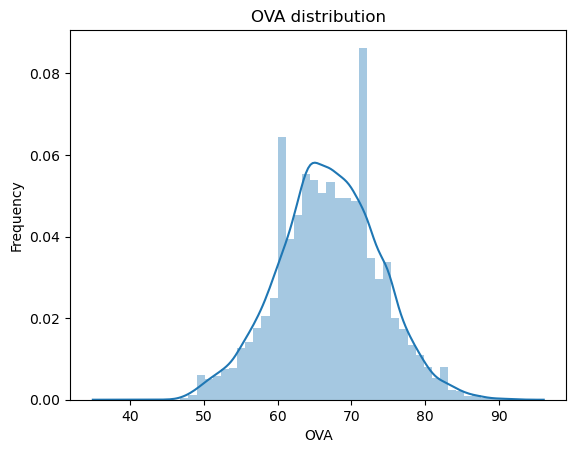

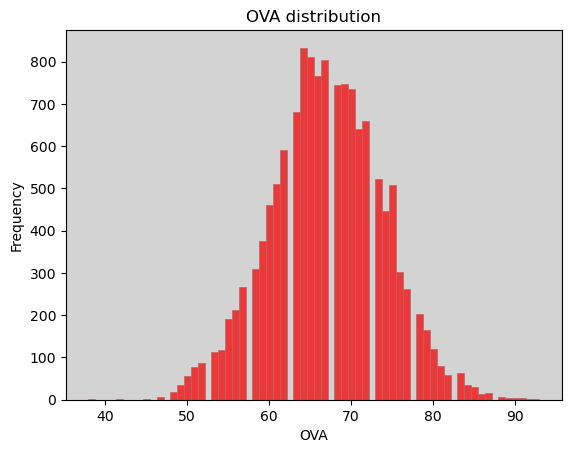

In [7]:
#histogram of OVA
sns.distplot(train_data['OVA'])
plt.xlabel('OVA')
plt.ylabel('Frequency')
plt.title('OVA distribution')
plt.show()
# same with seaborn
plt.gca().set_facecolor('lightgray')
sns.histplot(train_data['OVA'],color='red',edgecolor='grey', fill=True,shrink=1)
plt.xlabel('OVA')
plt.ylabel('Frequency')
plt.title('OVA distribution')
plt.show()

<Axes: title={'center': 'OVA vs Market Value'}, xlabel='OVA', ylabel='Market Value'>

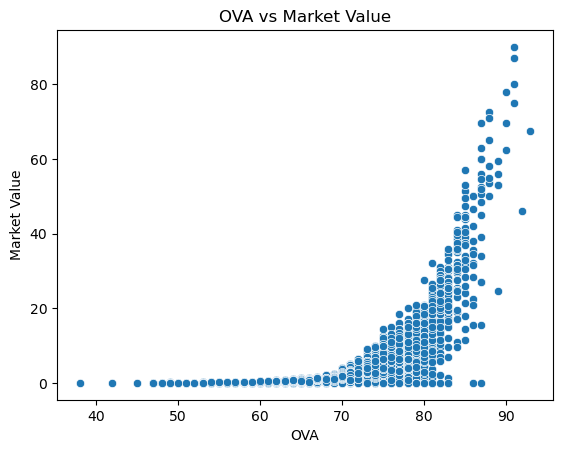

In [8]:
#scatterplotting OVA / Market Value distribution

ova_value=train_data.sort_values(['OVA'],ascending=False)[['OVA','Value_M']]

plt.xlabel('OVA')
plt.ylabel('Market Value')
plt.title('OVA vs Market Value')

sns.scatterplot(x=ova_value['OVA'], y=ova_value['Value_M'])

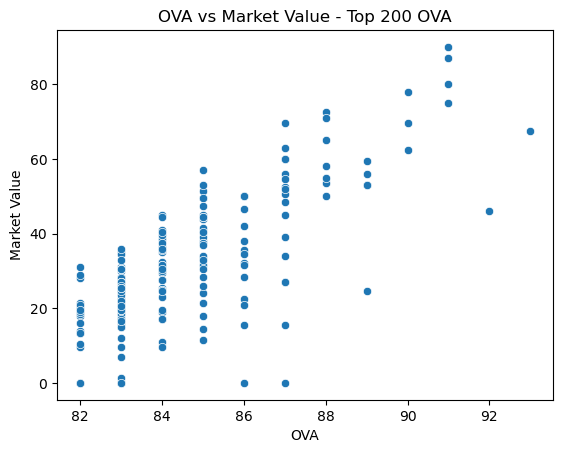

In [9]:
#scatterplotting OVA / Market Value distribution only for top200 OVA players

ova_value=train_data.sort_values(['OVA'],ascending=False)[['OVA','Value_M']].head(200)

plt.xlabel('OVA')
plt.ylabel('Market Value')
plt.title('OVA vs Market Value - Top 200 OVA')

sns.scatterplot(x=ova_value['OVA'], y=ova_value['Value_M'])
plt.show()

In [10]:
#exploring dataset to identify top OVA players
train_data.sort_values(['OVA'],ascending=False)[['Value_M','Value','Name','OVA']].head(5)

,Value_M,Value,Name,OVA
602,67.5,€67.5M,L. Messi,93
111,46.0,€46M,Cristiano Ronaldo,92
1845,80.0,€80M,R. Lewandowski,91
2946,75.0,€75M,J. Oblak,91
2138,90.0,€90M,Neymar Jr,91


In [11]:
#exploring dataset to identify most valuable players
train_data.sort_values(['Value_M'],ascending=False)[['Value_M','Value','Name','OVA']].head(5)

,Value_M,Value,Name,OVA
2138,90.0,€90M,Neymar Jr,91
2314,87.0,€87M,K. De Bruyne,91
1845,80.0,€80M,R. Lewandowski,91
4104,78.0,€78M,M. Salah,90
2946,75.0,€75M,J. Oblak,91


In [12]:
#counting number of players by position
train_data['BP'].groupby([train_data['BP']]).count()

BP
CAM    1796
CB     2553
CDM     988
CF       68
CM      783
GK     1281
LB      736
LM      657
LW      171
LWB     199
RB      721
RM     1135
RW      269
RWB     196
ST     2147
Name: BP, dtype: int64

In [13]:
#adding a new column dividing the original dataset in four parts, by position (train_data)
train_data['BP_grouped']=np.where(train_data["BP"]=="GK","GK",np.where(train_data["BP"].isin(["CB","LB","LWB","RB","RWB"]),"D",np.where(train_data["BP"].isin(["CAM","CDM","CM","LM","RM","RW","LW"]),"M",np.where(train_data["BP"].isin(["ST","CF"]),"ST",""))))

In [14]:
#creating four subsets, by position
train_data_GK=train_data[train_data["BP_grouped"]=="GK"]
train_data_D=train_data[train_data["BP_grouped"]=="D"]
train_data_M=train_data[train_data["BP_grouped"]=="M"]
train_data_ST=train_data[train_data["BP_grouped"]=="ST"]

print("train_data_GK.shape: ",train_data_GK.shape,"train_data_D.shape: ",train_data_D.shape,"\n","train_data_M.shape: ",train_data_M.shape,"train_data_ST.shape: ",train_data_ST.shape)

train_data_GK.shape:  (1281, 111) train_data_D.shape:  (4405, 111) 
 train_data_M.shape:  (5799, 111) train_data_ST.shape:  (2215, 111)


In [15]:
#defining a function identifying the correlated variables above a specific value

def correlations(df,corr_lower_bound):
    correlations_matrix = df.corr()
    high_correlations = correlations_matrix[correlations_matrix >= corr_lower_bound]
    high_correlations = high_correlations.mask(np.tril(np.ones(high_correlations.shape)).astype(bool))
    high_correlations_pairs = [(col1,col2) for col1 in high_correlations.columns for col2 in high_correlations.columns if not pd.isna(high_correlations[col1][col2])]
    OVA_correlations=pd.DataFrame([k for k in high_correlations_pairs if 'OVA' in k])[0]
    return OVA_correlations

In [16]:
#printing the most correlated variables with OVA, globally and by position
print("ALL: ",list(correlations(train_data,0.5).values),"\n\n","GK: ",list(correlations(train_data_GK,0.7).values),"\n\n","D: ",list(correlations(train_data_D,0.7).values),"\n\n","M: ",list(correlations(train_data_M,0.6).values),"\n\n","ST: ",list(correlations(train_data_ST,0.7).values))

ALL:  ['OVA', 'BOV', 'POT', 'Reactions', 'Power', 'Shot Power', 'Vision', 'Composure', 'Total Stats', 'Base Stats', 'PAS', 'DRI', 'PHY', 'Value_M'] 

 GK:  ['BOV', 'Reactions', 'Goalkeeping', 'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes', 'Total Stats', 'Base Stats', 'PAC', 'SHO', 'PAS', 'DRI', 'PHY'] 

 D:  ['BOV', 'Attacking', 'Short Passing', 'Long Passing', 'Ball Control', 'Reactions', 'Mentality', 'Interceptions', 'Composure', 'Defending', 'Marking', 'Standing Tackle', 'Sliding Tackle', 'Total Stats', 'Base Stats', 'PAS', 'DEF'] 

 M:  ['BOV', 'Attacking', 'Crossing', 'Finishing', 'Short Passing', 'Volleys', 'Skill', 'Dribbling', 'Curve', 'Long Passing', 'Ball Control', 'Reactions', 'Power', 'Shot Power', 'Long Shots', 'Mentality', 'Positioning', 'Vision', 'Composure', 'Total Stats', 'Base Stats', 'SHO', 'PAS', 'DRI', 'Value_M'] 

 ST:  ['BOV', 'Attacking', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill', 'Dribbling', 'Ball Control'

In [17]:
# defining a fuunction identifying multicolinearity (pairs of variables which correlation is above 0.9)

def correlations2(df,corr_lower_bound):
    correlations_matrix = df.corr()
    high_correlations = correlations_matrix[correlations_matrix >= abs(corr_lower_bound)]
    high_correlations = high_correlations.mask(np.tril(np.ones(high_correlations.shape)).astype(bool))
    high_correlations_pairs = [(col1,col2) for col1 in high_correlations.columns for col2 in high_correlations.columns if not pd.isna(high_correlations[col1][col2])]
    correlations=pd.DataFrame([k for k in high_correlations_pairs])
    return correlations

In [18]:
# identifying multicolinearity (pairs of variables which correlation is above 0.9) on the variables correlated with OVA 

multicolinearity_ALL = train_data[correlations(train_data,0.5)]
multicolinearity_GK = train_data_GK[correlations(train_data_GK,0.7)]
multicolinearity_D = train_data_D[correlations(train_data_D,0.7)]
multicolinearity_M = train_data_D[correlations(train_data_M,0.6)]
multicolinearity_ST = train_data_ST[correlations(train_data_ST,0.7)]

print("ALL: ",correlations2(multicolinearity_ALL,0.9).values.tolist(),"\n")
print("GK: ",correlations2(multicolinearity_GK,0.9).values.tolist(),"\n")
print("D: ",correlations2(multicolinearity_D,0.9).values.tolist(),"\n")
print("M: ",correlations2(multicolinearity_M,0.9).values.tolist(),"\n")
print("ST: ",correlations2(multicolinearity_ST,0.9).values.tolist(),"\n")

ALL:  [['BOV', 'OVA']] 

GK:  [['Goalkeeping', 'BOV'], ['GK Diving', 'BOV'], ['GK Diving', 'Goalkeeping'], ['GK Handling', 'BOV'], ['GK Handling', 'Goalkeeping'], ['GK Positioning', 'BOV'], ['GK Positioning', 'Goalkeeping'], ['GK Reflexes', 'BOV'], ['GK Reflexes', 'Goalkeeping'], ['GK Reflexes', 'GK Diving'], ['Base Stats', 'BOV'], ['Base Stats', 'Goalkeeping'], ['Base Stats', 'GK Diving'], ['Base Stats', 'GK Handling'], ['Base Stats', 'GK Positioning'], ['Base Stats', 'GK Reflexes'], ['PAC', 'BOV'], ['PAC', 'Goalkeeping'], ['PAC', 'GK Diving'], ['PAC', 'GK Reflexes'], ['PAC', 'Base Stats'], ['SHO', 'BOV'], ['SHO', 'Goalkeeping'], ['SHO', 'GK Handling'], ['SHO', 'Base Stats'], ['PAS', 'GK Kicking'], ['DRI', 'BOV'], ['DRI', 'Goalkeeping'], ['DRI', 'GK Diving'], ['DRI', 'GK Reflexes'], ['DRI', 'Base Stats'], ['DRI', 'PAC'], ['PHY', 'BOV'], ['PHY', 'Goalkeeping'], ['PHY', 'GK Positioning'], ['PHY', 'Base Stats']] 

D:  [['Defending', 'BOV'], ['Marking', 'Defending'], ['Standing Tackle', '

In [19]:
#removing high correlated (>0.9) predictor variables to apply the model

ALL=list(correlations(train_data,0.5))
items_to_remove = ["POT","BOV","Total Stats","Base Stats"]   #POT is not in test data
ALL = [item for item in ALL if item not in items_to_remove]
multicolinearity_ALL = train_data[ALL]
print("ALL: ",correlations2(multicolinearity_ALL,0.9).values.tolist())

GK=list(correlations(train_data_GK,0.7))
items_to_remove = ['BOV','GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes', 'Total Stats', 'Base Stats']
GK = [item for item in GK if item not in items_to_remove]  
multicolinearity_GK = train_data[GK]
print("GK: ",correlations2(multicolinearity_GK,0.9).values.tolist())

D=list(correlations(train_data_D,0.7))
items_to_remove = ['BOV','Marking','Short Passing','Sliding Tackle', 'Standing Tackle','Interceptions','DEF', 'Attacking', 'Total Stats', 'Base Stats']
D = [item for item in D if item not in items_to_remove] 
multicolinearity_D = train_data[D]
print("D: ",correlations2(multicolinearity_D,0.9).values.tolist())  

M=list(correlations(train_data_M,0.65))
items_to_remove = ['BOV','Attacking','Short Passing','Dribbling','Curve','Ball Control','Total Stats', 'Base Stats']
M = [item for item in M if item not in items_to_remove] 
multicolinearity_M = train_data[M]
print("M: ",correlations2(multicolinearity_M,0.9).values.tolist())  

ST=list(correlations(train_data_ST,0.7))
items_to_remove = ['BOV','Positioning', 'Short Passing', 'Dribbling','Skill','Ball Control', 'Vision','Total Stats', 'Base Stats']
ST = [item for item in ST if item not in items_to_remove] 
multicolinearity_ST = train_data[ST]
print("ST: ",correlations2(multicolinearity_ST,0.9).values.tolist()) 


ALL:  []
GK:  []
D:  []
M:  []
ST:  []


In [20]:
#adding categorical variables needed for the following steps

ALL.extend(['Name','BP_grouped'])
GK.extend(['Name','OVA','Value_M','BP_grouped'])   
D.extend(['Name','OVA','Value_M','BP_grouped'])
M.extend(['Name','OVA','Value_M','BP_grouped'])
ST.extend(['Name','OVA','Value_M','BP_grouped'])

print("ALL: ",ALL,"\n\n","GK: ",GK,"\n\n","D: ",D,"\n\n","M: ",M,"\n\n","ST: ",ST)


ALL:  ['OVA', 'Reactions', 'Power', 'Shot Power', 'Vision', 'Composure', 'PAS', 'DRI', 'PHY', 'Value_M', 'Name', 'BP_grouped'] 

 GK:  ['Reactions', 'Goalkeeping', 'PAC', 'SHO', 'PAS', 'DRI', 'PHY', 'Name', 'OVA', 'Value_M', 'BP_grouped'] 

 D:  ['Long Passing', 'Ball Control', 'Reactions', 'Mentality', 'Composure', 'Defending', 'PAS', 'Name', 'OVA', 'Value_M', 'BP_grouped'] 

 M:  ['Crossing', 'Skill', 'Long Passing', 'Reactions', 'Power', 'Shot Power', 'Long Shots', 'Mentality', 'Positioning', 'Vision', 'Composure', 'SHO', 'PAS', 'DRI', 'Name', 'OVA', 'Value_M', 'BP_grouped'] 

 ST:  ['Attacking', 'Finishing', 'Heading Accuracy', 'Volleys', 'Reactions', 'Power', 'Shot Power', 'Long Shots', 'Mentality', 'Composure', 'SHO', 'PAS', 'DRI', 'Name', 'OVA', 'Value_M', 'BP_grouped']


In [21]:
#defining function counting NAs and percentage of NAs by variable

def check_NA(df,variables):
    model=df[variables]
    print(model.isna().sum().sum())
    print("\n",model.isna().sum() / len(model))

In [22]:
#counting NAs and percentage of NAs by variable (all under 3% so we decided to drop)

check_NA(train_data,ALL)
check_NA(train_data_GK,GK)
check_NA(train_data_D,D)
check_NA(train_data_M,M)
check_NA(train_data_ST,ST)

373

 OVA           0.000000
Reactions     0.000000
Power         0.000000
Shot Power    0.000000
Vision        0.003212
Composure     0.024015
PAS           0.000000
DRI           0.000000
PHY           0.000000
Value_M       0.000000
Name          0.000000
BP_grouped    0.000000
dtype: float64
0

 Reactions      0.0
Goalkeeping    0.0
PAC            0.0
SHO            0.0
PAS            0.0
DRI            0.0
PHY            0.0
Name           0.0
OVA            0.0
Value_M        0.0
BP_grouped     0.0
dtype: float64
100

 Long Passing    0.000000
Ball Control    0.000000
Reactions       0.000000
Mentality       0.000000
Composure       0.022701
Defending       0.000000
PAS             0.000000
Name            0.000000
OVA             0.000000
Value_M         0.000000
BP_grouped      0.000000
dtype: float64
141

 Crossing        0.000000
Skill           0.000000
Long Passing    0.000000
Reactions       0.000000
Power           0.000000
Shot Power      0.000000
Long Shots      0.00000

In [23]:
#dropping NA's

model_ALL=train_data[ALL].dropna()
model_GK=train_data_GK[GK].dropna()
model_D=train_data_D[D].dropna()
model_M=train_data_M[M].dropna()
model_ST=train_data_ST[ST].dropna()

print("Global: ",model_ALL.shape)
print("GK: ",model_GK.shape)
print("D: ",model_D.shape)
print("M: ",model_M.shape)
print("ST: ",model_ST.shape)

Global:  (13371, 12)
GK:  (1281, 11)
D:  (4305, 11)
M:  (5667, 18)
ST:  (2142, 17)


In [24]:
#defining function applying the linear regression model (for global and by position)

def regmodel(df,list_variables):
    Y=df['OVA']
    X=df[list_variables].drop(['Name','OVA','Value_M','BP_grouped'],axis=1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    coefficients=model.params
    ypred=round(model.predict(X),2)
    r2=round(r2_score(Y,ypred),3)
    mse=round(mean_squared_error(Y,ypred),3)
    rmse=round(math.sqrt(mean_squared_error(Y,ypred)),3)
    mae=round(mean_absolute_error(Y,ypred),3)
    return (ypred,r2,mse,rmse,mae,coefficients)
   

In [25]:
#R2, MSE, RMSE and MAE of the global model
#R2, MSE, RMSE and MAE of the models by position

print("Global  R2",regmodel(model_ALL,ALL)[1],"MSE",regmodel(model_ALL,ALL)[2],"RMSE",regmodel(model_ALL,ALL)[3],"MAE",regmodel(model_ALL,ALL)[4])
print("GK      R2",regmodel(model_GK,GK)[1],"MSE",regmodel(model_GK,GK)[2],"RMSE",regmodel(model_GK,GK)[3],"MAE",regmodel(model_GK,GK)[4])
print("D       R2",regmodel(model_D,D)[1],"MSE",regmodel(model_D,D)[2],"RMSE",regmodel(model_D,D)[3],"MAE",regmodel(model_D,D)[4])
print("M       R2",regmodel(model_M,M)[1],"MSE",regmodel(model_M,M)[2],"RMSE",regmodel(model_M,M)[3],"MAE",regmodel(model_M,M)[4])
print("ST      R2",regmodel(model_ST,ST)[1],"MSE",regmodel(model_ST,ST)[2],"RMSE",regmodel(model_ST,ST)[3],"MAE",regmodel(model_ST,ST)[4])

Global  R2 0.863 MSE 6.38 RMSE 2.526 MAE 1.995
GK      R2 0.998 MSE 0.126 RMSE 0.356 MAE 0.286
D       R2 0.944 MSE 2.45 RMSE 1.565 MAE 1.237
M       R2 0.92 MSE 3.653 RMSE 1.911 MAE 1.476
ST      R2 0.979 MSE 0.972 RMSE 0.986 MAE 0.757


In [26]:
#normalization of dataset, did not improve the R2
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(model_ALL.drop(['Name','BP_grouped','Value_M'],axis=1))
normalized_data = pd.DataFrame(normalized_data, columns=model_ALL.drop(['Name','BP_grouped','Value_M'],axis=1).columns)

Y = normalized_data['OVA']
X = normalized_data.drop(['OVA'],axis=1)
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
model.summary()
ypred=round(model.predict(X),2)
print("R2: ",round(r2_score(Y,ypred),3))

R2:  0.863


In [27]:
#joining the four partial models by position into a single model
#checking R2, MSE, RMSE and MAE of the model

model_GK['Predictions']=regmodel(model_GK,GK)[0]
model_D['Predictions']=regmodel(model_D,D)[0]
model_M['Predictions']=regmodel(model_M,M)[0]
model_ST['Predictions']=regmodel(model_ST,ST)[0]

GK2=model_GK[['Name','Value_M','OVA','Predictions','BP_grouped']]
D2=model_D[['Name','Value_M','OVA','Predictions','BP_grouped']]
M2=model_M[['Name','Value_M','OVA','Predictions','BP_grouped']]
ST2=model_ST[['Name','Value_M','OVA','Predictions','BP_grouped']]

model2=pd.concat([GK2,D2,M2,ST2])
model2_r2=round(r2_score(model2['OVA'],model2['Predictions']),3)
model2_mse=round(mean_squared_error(model2['OVA'],model2['Predictions']),3)
model2_rmse=round(math.sqrt(mean_squared_error(model2['OVA'],model2['Predictions'])),3)
model2_mae=round(mean_absolute_error(model2['OVA'],model2['Predictions']),3)
print("R2:",model2_r2,"MSE:",model2_mse,"RMSE:",model2_rmse,"MAE:",model2_mae)

R2: 0.946 MSE: 2.5 RMSE: 1.581 MAE: 1.17


In [28]:
#comparing the predictions to the real OVA for the top-players (sorted by predictions)

print(model2.sort_values(['Predictions'],ascending=False)[['Name','OVA','Value_M','Predictions']].head(10))

                   Name  OVA  Value_M  Predictions
111   Cristiano Ronaldo   92     46.0        91.65
602            L. Messi   93     67.5        90.82
2314       K. De Bruyne   91     87.0        90.04
2946           J. Oblak   91     75.0        89.97
4636            Alisson   90     62.5        89.27
1845     R. Lewandowski   91     80.0        88.83
2254      M. ter Stegen   90     69.5        88.59
544        Sergio Ramos   89     24.5        88.51
528           S. Agüero   89     53.0        88.20
2138          Neymar Jr   91     90.0        88.05


In [29]:
#comparing the predictions to the real OVA for the top-players (sorted by OVA)

print(model2.sort_values(['OVA'],ascending=False)[['Name','OVA','Value_M','Predictions']].head(10))

                   Name  OVA  Value_M  Predictions
602            L. Messi   93     67.5        90.82
111   Cristiano Ronaldo   92     46.0        91.65
1845     R. Lewandowski   91     80.0        88.83
2314       K. De Bruyne   91     87.0        90.04
2946           J. Oblak   91     75.0        89.97
2138          Neymar Jr   91     90.0        88.05
4636            Alisson   90     62.5        89.27
4104           M. Salah   90     78.0        87.48
2254      M. ter Stegen   90     69.5        88.59
2213        T. Courtois   89     56.0        86.61


In [30]:
#defining function to find top3 predicted players
#the function group all possible combinations of three diferent players and return the sum of combined market value under €100M

def top3(df):
    
    sum_Pred=[]
    sum_Value=[]
    pred_player_i=[]
    pred_player_j=[]
    pred_player_k=[]
    names_i=[]
    names_j=[]
    names_k=[]
    OVA_player_i=[]
    OVA_player_j=[]
    OVA_player_k=[]

    for i in range(50):
        for j in range(50):
            if (j>i):
                for k in range(50):
                    if(k>j and k>i):
                        sum_Pred.append(df.iloc[i,2]+df.iloc[j,2]+df.iloc[k,2])
                        names_i.append(df.iloc[i,0])
                        names_j.append(df.iloc[j,0])
                        names_k.append(df.iloc[k,0])
                        sum_Value.append(df.iloc[i,3]+df.iloc[j,3]+df.iloc[k,3])
                        pred_player_i.append(df.iloc[i,2])
                        pred_player_j.append(df.iloc[j,2])
                        pred_player_k.append(df.iloc[k,2])
                        OVA_player_i.append(df.iloc[i,1])
                        OVA_player_j.append(df.iloc[j,1])
                        OVA_player_k.append(df.iloc[k,1])
                    
    final=pd.DataFrame([names_i,names_j,names_k,sum_Pred,sum_Value,OVA_player_i,pred_player_i,OVA_player_j,pred_player_j,OVA_player_k,pred_player_k]).transpose()
    final.columns = ['Player1', 'Player2', 'Player3','sum_Pred','sum_Value','OVA_Player1','Pred_Player1','OVA_Player2','Pred_Player2','OVA_Player3','Pred_Player3']

    #applying the filter of budget limit
    c=final[final['sum_Value']<=100]

    return c

In [31]:
#printing the best solutions sorted by sum_Prediction

b=model2.sort_values(['OVA'],ascending=False)[['Name','OVA','Predictions','Value_M','BP_grouped']].head(60)
print(top3(b).sort_values(['sum_Pred'],ascending=False)[['Player1', 'Player2', 'Player3','sum_Pred','sum_Value','OVA_Player1','Pred_Player1','OVA_Player2','Pred_Player2','OVA_Player3','Pred_Player3']].head(10),"\n")

                Player1       Player2       Player3 sum_Pred sum_Value  \
1548  Cristiano Ronaldo  Sergio Ramos     H. Lloris   266.36      97.5   
1559  Cristiano Ronaldo  Sergio Ramos         Piqué   266.27      91.5   
1538  Cristiano Ronaldo  Sergio Ramos      K. Navas    266.2      97.5   
1550  Cristiano Ronaldo  Sergio Ramos   David Silva   266.05      93.0   
1552  Cristiano Ronaldo  Sergio Ramos     Y. Sommer   265.63      99.0   
1535  Cristiano Ronaldo  Sergio Ramos  G. Chiellini   264.98      86.0   
2209  Cristiano Ronaldo     H. Lloris         Piqué   263.96      94.0   
2013  Cristiano Ronaldo      K. Navas     H. Lloris   263.89     100.0   
2024  Cristiano Ronaldo      K. Navas         Piqué    263.8      94.0   
2200  Cristiano Ronaldo     H. Lloris   David Silva   263.74      95.5   

     OVA_Player1 Pred_Player1 OVA_Player2 Pred_Player2 OVA_Player3  \
1548          92        91.65          89        88.51          87   
1559          92        91.65          89    

In [32]:
#printing the best solutions sorted by sum_OVA
print(top3(b).sort_values(['sum_Pred'],ascending=False)[['Player1', 'Player2', 'Player3','sum_Pred','sum_Value','OVA_Player1','Pred_Player1','OVA_Player2','Pred_Player2','OVA_Player3','Pred_Player3']].head(10),"\n")

                Player1       Player2       Player3 sum_Pred sum_Value  \
1548  Cristiano Ronaldo  Sergio Ramos     H. Lloris   266.36      97.5   
1559  Cristiano Ronaldo  Sergio Ramos         Piqué   266.27      91.5   
1538  Cristiano Ronaldo  Sergio Ramos      K. Navas    266.2      97.5   
1550  Cristiano Ronaldo  Sergio Ramos   David Silva   266.05      93.0   
1552  Cristiano Ronaldo  Sergio Ramos     Y. Sommer   265.63      99.0   
1535  Cristiano Ronaldo  Sergio Ramos  G. Chiellini   264.98      86.0   
2209  Cristiano Ronaldo     H. Lloris         Piqué   263.96      94.0   
2013  Cristiano Ronaldo      K. Navas     H. Lloris   263.89     100.0   
2024  Cristiano Ronaldo      K. Navas         Piqué    263.8      94.0   
2200  Cristiano Ronaldo     H. Lloris   David Silva   263.74      95.5   

     OVA_Player1 Pred_Player1 OVA_Player2 Pred_Player2 OVA_Player3  \
1548          92        91.65          89        88.51          87   
1559          92        91.65          89    

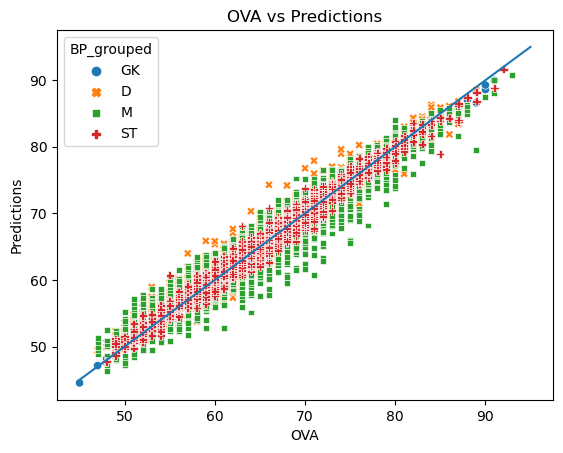

In [33]:
# plotting OVA vs predictions, by position
# for the best players (OVA 85 and above), the model tends to underestimate OVA comparing to players under 85

ova_pred=model2.sort_values(['OVA'],ascending=False)[['OVA','Predictions','BP_grouped']]

plt.xlabel('OVA')
plt.ylabel('Predictions')
plt.title('OVA vs Predictions')

sns.scatterplot(x=model2['OVA'], y=model2['Predictions'], hue=model2['BP_grouped'], style=model2['BP_grouped'])
plt.plot([45, 95], [45, 95])
plt.show()

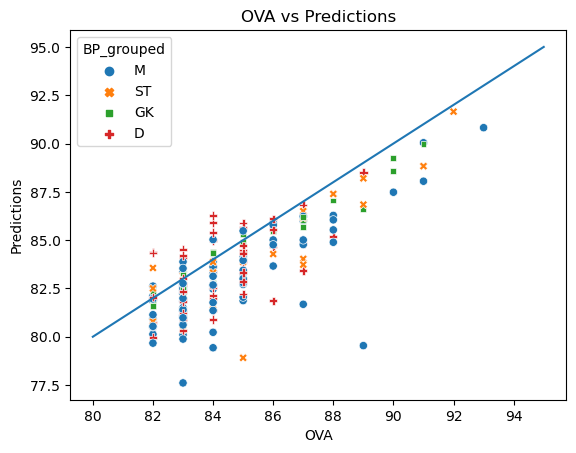

In [34]:
# plotting OVA vs predictions, by position, only for top200 players
# for the best players (OVA 85 and above), the model tends to underestimate OVA comparing to players under 85

ova_pred=model2.sort_values(['OVA'],ascending=False)[['OVA','Predictions','BP_grouped']].head(200)

plt.xlabel('OVA')
plt.ylabel('Predictions')
plt.title('OVA vs Predictions')

sns.scatterplot(x=ova_pred['OVA'], y=ova_pred['Predictions'], hue=ova_pred['BP_grouped'], style=ova_pred['BP_grouped'])
plt.plot([80, 95], [80, 95])
plt.show()

In [35]:
#standardizing and converting market value to numeric variable - test data

transform_dataframe(test_data)
test_data[['Value','Value_M']].head(5)

,Value,Value_M
0,€325K,0.325
1,€975K,0.975
2,€400K,0.400
3,€0,0.000
4,€6M,6.000


In [36]:
#adding a new column dividing the original dataset in four parts, by position (test_data)
#creating four subsets, by position (test_data)

test_data['BP_grouped']=np.where(test_data["BP"]=="GK","GK",np.where(test_data["BP"].isin(["CB","LB","LWB","RB","RWB"]),"D",np.where(test_data["BP"].isin(["CAM","CDM","CM","LM","RM","RW","LW"]),"M",np.where(test_data["BP"].isin(["ST","CF"]),"ST",""))))

test_data_GK=test_data[test_data["BP_grouped"]=="GK"]
test_data_D=test_data[test_data["BP_grouped"]=="D"]
test_data_M=test_data[test_data["BP_grouped"]=="M"]
test_data_ST=test_data[test_data["BP_grouped"]=="ST"]

print("test_data_GK.shape: ",test_data_GK.shape,"test_data_D.shape: ",test_data_D.shape,"\n","test_data_M.shape: ",test_data_M.shape,"test_data_ST.shape: ",test_data_ST.shape)

test_data_GK.shape:  (295, 107) test_data_D.shape:  (1166, 107) 
 test_data_M.shape:  (1430, 107) test_data_ST.shape:  (534, 107)


In [37]:
#selecting only the predictors found in train data

remove_set = {'Name','OVA','Value_M','BP_grouped'}
GK2 = [item for item in GK if item not in remove_set]
D2 = [item for item in D if item not in remove_set]
M2 = [item for item in M if item not in remove_set]
ST2 = [item for item in ST if item not in remove_set]


In [38]:
#applying the model found in the train data to the test data
#printing the top players predicted by the model

Y=model_GK['OVA']
X=model_GK[GK2]
X=sm.add_constant(X)
model = sm.OLS(Y,X).fit()
test_model_GK=test_data_GK[GK2].dropna()
test_model_GK=sm.add_constant(test_model_GK)
ypred_GK=round(model.predict(test_model_GK),2)

Y=model_D['OVA']
X=model_D[D2]
X=sm.add_constant(X)
model = sm.OLS(Y,X).fit()
test_model_D=test_data_D[D2].dropna()
test_model_D=sm.add_constant(test_model_D)
ypred_D=round(model.predict(test_model_D),2)

Y=model_M['OVA']
X=model_M[M2]
X=sm.add_constant(X)
model = sm.OLS(Y,X).fit()
test_model_M=test_data_M[M2].dropna()
test_model_M=sm.add_constant(test_model_M)
ypred_M=round(model.predict(test_model_M),2)

Y=model_ST['OVA']
X=model_ST[ST2]
X=sm.add_constant(X)
model = sm.OLS(Y,X).fit()
test_model_ST=test_data_ST[ST2].dropna()
test_model_ST=sm.add_constant(test_model_ST)
ypred_ST=round(model.predict(test_model_ST),2)


test_data_ST['Prediction']=ypred_ST
test_data_M['Prediction']=ypred_M
test_data_D['Prediction']=ypred_D
test_data_GK['Prediction']=ypred_GK

model2_test=pd.concat([test_data_ST,test_data_M,test_data_D,test_data_GK])[['Name','Value_M','Prediction','BP_grouped']]

model2_test.sort_values(['Prediction'],ascending=False)[['Name','Value_M','Prediction','BP_grouped']].head(10)


,Name,Value_M,Prediction,BP_grouped
1272,P. Lahm,29.5,89.56,D
494,V. van Dijk,75.5,88.39,D
992,M. Neuer,29.0,88.32,GK
1912,S. Mané,78.0,88.07,M
726,L. Modrić,24.5,87.57,M
2521,S. Handanovič,16.0,87.49,GK
1836,M. Hummels,33.0,87.43,D
158,K. Mbappé,105.5,87.30,ST
2347,L. Suárez,31.5,87.26,ST
2386,O. Kahn,0.0,86.93,GK


In [39]:
# defining a function finding the top-3 players which sum of market value is under €100M

def top3_predict(df):
    
    sum_Pred=[]
    sum_Value=[]
    names_i=[]
    names_j=[]
    names_k=[]
    value_i=[]
    value_j=[]
    value_k=[]
    pred_i=[]
    pred_j=[]
    pred_k=[]

#for each combination of three players, we store the predictions, the names, the market value (individual and global)
#prediction was rounded up for the next integer
    
    for i in range(50):
        for j in range(50):
            if (j>i):
                for k in range(50):
                    if(k>j and k>i):
                        sum_Pred.append(math.ceil(b.iloc[i,2])+math.ceil(b.iloc[j,2])+math.ceil(b.iloc[k,2]))
                        names_i.append(b.iloc[i,0])
                        names_j.append(b.iloc[j,0])
                        names_k.append(b.iloc[k,0])
                        sum_Value.append(b.iloc[i,1]+b.iloc[j,1]+b.iloc[k,1])
                        value_i.append(b.iloc[i,1])
                        value_j.append(b.iloc[j,1])
                        value_k.append(b.iloc[k,1])
                        pred_i.append(math.ceil(b.iloc[i,2]))
                        pred_j.append(math.ceil(b.iloc[j,2]))
                        pred_k.append(math.ceil(b.iloc[k,2]))
                    
    final=pd.DataFrame([names_i,names_j,names_k,sum_Pred,sum_Value,value_i,value_j,value_k,pred_i,pred_j,pred_k]).transpose()
    final.columns = ['Player1', 'Player2', 'Player3','sum_Pred','sum_Value','Value_Player1','Value_Player2','Value_Player3','Pred_Player1','Pred_Player2','Pred_Player3']

#applying the filter of budget limit
    c=final[final['sum_Value']<=100]

    return c
    

In [43]:
#printing the best solutions sorted by sum_Prediction

b=model2_test.sort_values(['Prediction'],ascending=False)[['Name','Value_M','Prediction','BP_grouped']].head(60)
print(top3_predict(b).sort_values(['sum_Pred'],ascending=False)[['Player1', 'Player2', 'Player3','sum_Pred','sum_Value','Value_Player1','Value_Player2','Value_Player3','Pred_Player1','Pred_Player2','Pred_Player3']].head(10),"\n")

     Player1        Player2        Player3 sum_Pred sum_Value Value_Player1  \
49   P. Lahm       M. Neuer      L. Modrić      267      83.0          29.5   
51   P. Lahm       M. Neuer     M. Hummels      267      91.5          29.5   
53   P. Lahm       M. Neuer      L. Suárez      267      90.0          29.5   
50   P. Lahm       M. Neuer  S. Handanovič      267      74.5          29.5   
141  P. Lahm      L. Modrić  S. Handanovič      266      70.0          29.5   
144  P. Lahm      L. Modrić      L. Suárez      266      85.5          29.5   
186  P. Lahm  S. Handanovič     M. Hummels      266      78.5          29.5   
188  P. Lahm  S. Handanovič      L. Suárez      266      77.0          29.5   
231  P. Lahm     M. Hummels      L. Suárez      266      94.0          29.5   
142  P. Lahm      L. Modrić     M. Hummels      266      87.0          29.5   

    Value_Player2 Value_Player3 Pred_Player1 Pred_Player2 Pred_Player3  
49           29.0          24.5           90           89

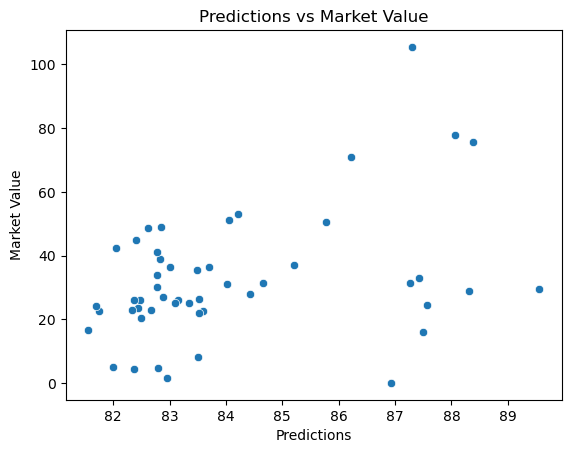

In [41]:
# scatterplotting predictions vs Market Value

graph=model2_test.sort_values(['Prediction'],ascending=False)[['Prediction','Value_M','Name']].head(50)

plt.xlabel('Predictions')
plt.ylabel('Market Value')
plt.title('Predictions vs Market Value')

sns.scatterplot(x=graph['Prediction'], y=graph['Value_M'])
plt.show()


In [370]:
#final solution 

final_solution=top3_predict(b).sort_values(['sum_Pred'],ascending=False)[['Player1', 'Player2', 'Player3','sum_Pred','sum_Value','Value_Player1','Value_Player2','Value_Player3','Pred_Player1','Pred_Player2','Pred_Player3']].head(1)
final_solution

,Player1,Player2,Player3,sum_Pred,sum_Value,Value_Player1,Value_Player2,Value_Player3,Pred_Player1,Pred_Player2,Pred_Player3
49,P. Lahm,M. Neuer,L. Modrić,267,83.0,29.5,29.0,24.5,90,89,88
